In [2]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import numpy as np
import sys

In [3]:
sc = pyspark.SparkContext.getOrCreate()
spark = SparkSession.builder.appName('BigDataApp').getOrCreate()

In [4]:
path = "../data/processed/accidents/*.csv"
dgt_path = "../data/raw/drivers/cens_bcn_uab.csv"
dataDF = spark.read.format("csv").option("header", "true").load(path)

In [5]:
# ref: https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
def autolabel(rects, xpos='center', sign=''):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate(('{}' + sign).format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

## Number of Accidents per Sex

In [6]:
person_types = dataDF.select("descripcio_tipus_persona").distinct()
person_types_lst = [row.descripcio_tipus_persona for row in person_types.collect()]

driverDF = dataDF.filter(dataDF.descripcio_tipus_persona == "Conductor")
drvr_manDF = driverDF.filter(driverDF.descripcio_sexe == "Home")
drvr_womanDF = driverDF.filter(driverDF.descripcio_sexe == "Dona")
drvr_unknownDF = driverDF.filter(driverDF.descripcio_sexe == "Desconegut")

passerbyDF = dataDF.filter(dataDF.descripcio_tipus_persona == "Vianant")
passrb_manDF = passerbyDF.filter(passerbyDF.descripcio_sexe == "Home")
passrb_womanDF = passerbyDF.filter(passerbyDF.descripcio_sexe == "Dona")
passrb_unknownDF = passerbyDF.filter(passerbyDF.descripcio_sexe == "Desconegut")

passengerDF = dataDF.filter(dataDF.descripcio_tipus_persona == "Passatger")
pssng_manDF = passengerDF.filter(passerbyDF.descripcio_sexe == "Home")
pssng_womanDF = passengerDF.filter(passerbyDF.descripcio_sexe == "Dona")
pssng_unknownDF = passengerDF.filter(passerbyDF.descripcio_sexe == "Desconegut")

man_lst = [drvr_manDF.count(), passrb_manDF.count(), pssng_manDF.count()]
woman_lst = [drvr_womanDF.count(), passrb_womanDF.count(), pssng_womanDF.count()]
unknown_lst = [drvr_unknownDF.count(), passrb_unknownDF.count(), pssng_unknownDF.count()]

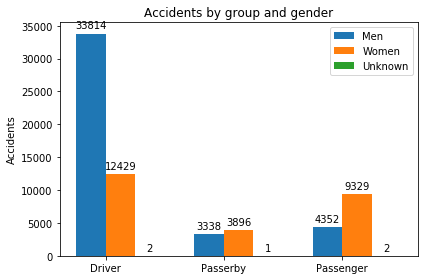

In [7]:
ind = np.arange(len(man_lst))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, man_lst, width, label='Men')
rects2 = ax.bar(ind + width/2, woman_lst, width, label='Women')
rects3 = ax.bar(ind + width*1.5, unknown_lst, width, label='Unknown')

ax.set_ylabel('Accidents')
ax.set_title('Accidents by group and gender')
ax.set_xticks(ind)
ax.set_xticklabels(('Driver', 'Passerby', 'Passenger'))
ax.legend()

autolabel(rects1, "center")
autolabel(rects2, "center")
autolabel(rects3, "center")

fig.tight_layout()
plt.show()

## Passerby Accidents by Age

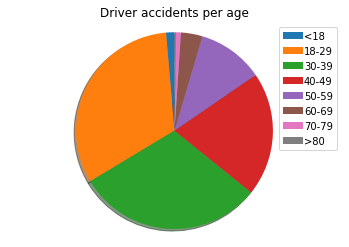

In [8]:
agelt18 = driverDF.filter(driverDF.edat < 18).count()
age18_29 = driverDF.filter((driverDF.edat >= 18) & (driverDF.edat <= 29)).count()
age30_39 = driverDF.filter((driverDF.edat >= 30) & (driverDF.edat <= 39)).count()
age40_49 = driverDF.filter((driverDF.edat >= 40) & (driverDF.edat <= 49)).count()
age50_59 = driverDF.filter((driverDF.edat >= 50) & (driverDF.edat <= 59)).count()
age60_69 = driverDF.filter((driverDF.edat >= 60) & (driverDF.edat <= 69)).count()
age70_79 = driverDF.filter((driverDF.edat >= 70) & (driverDF.edat <= 79)).count()
agegt80 = driverDF.filter(driverDF.edat >= 80).count()

labels = ['<18', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '>80']
sizes = [agelt18, age18_29, age30_39, age40_49, age50_59, age60_69, age70_79, agegt80]

fig1, ax1 = plt.subplots()
slices = []
pie = ax1.pie(sizes, shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Driver accidents per age')
plt.legend(labels=labels, handletextpad=0.1)
plt.show()

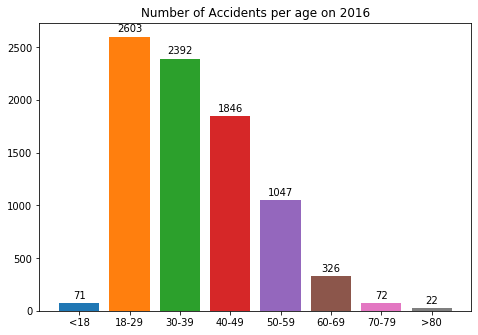

In [9]:
agelt18 = driverDF.filter((driverDF.edat < 18) & (driverDF.nk_any == 2016)).count()
age18_29 = driverDF.filter((driverDF.edat >= 18) & (driverDF.edat <= 29) & (driverDF.nk_any == 2016)).count()
age30_39 = driverDF.filter((driverDF.edat >= 30) & (driverDF.edat <= 39) & (driverDF.nk_any == 2016)).count()
age40_49 = driverDF.filter((driverDF.edat >= 40) & (driverDF.edat <= 49) & (driverDF.nk_any == 2016)).count()
age50_59 = driverDF.filter((driverDF.edat >= 50) & (driverDF.edat <= 59) & (driverDF.nk_any == 2016)).count()
age60_69 = driverDF.filter((driverDF.edat >= 60) & (driverDF.edat <= 69) & (driverDF.nk_any == 2016)).count()
age70_79 = driverDF.filter((driverDF.edat >= 70) & (driverDF.edat <= 79) & (driverDF.nk_any == 2016)).count()
agegt80 = driverDF.filter((driverDF.edat >= 80) & (driverDF.nk_any == 2016)).count()

sizes = [agelt18, age18_29, age30_39, age40_49, age50_59, age60_69, age70_79, agegt80]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bars = []
for label, size in zip(labels, sizes):
    tmp_ax = ax.bar(label, size)
    autolabel(tmp_ax, "center")
plt.title("Number of Accidents per age on 2016")
plt.show()

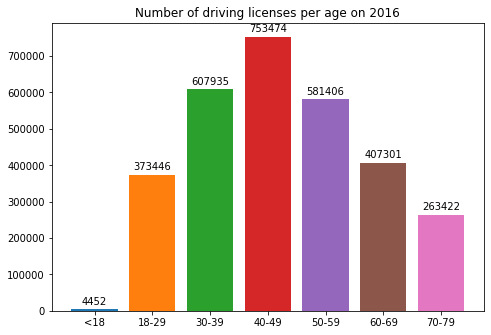

In [10]:
# Census from: https://iermbdb.uab.cat/index.php?ap=0&id_ind=1184&id_cat=
DGT_census = spark.read.format("csv").option("header", "true").load(dgt_path)
col_2016 = [idx for idx, col in enumerate(DGT_census.columns) if "2016" in col][0]
total_drivers = DGT_census.rdd.map(lambda x: int(x[col_2016].replace('.', ''))).collect()
age_distribution = [[0,1],[2,3,4],[5,6],[7,8],[9,10],[11,12],[13,14]]  # Age distribution to match 10-years format
total_ages = [sum([total_drivers[y] for y in x]) for x in age_distribution]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bars = []
for label, size in zip(labels, total_ages):
    tmp_ax = ax.bar(label, size)
    autolabel(tmp_ax, "center")
plt.title("Number of driving licenses per age on 2016")
plt.show()

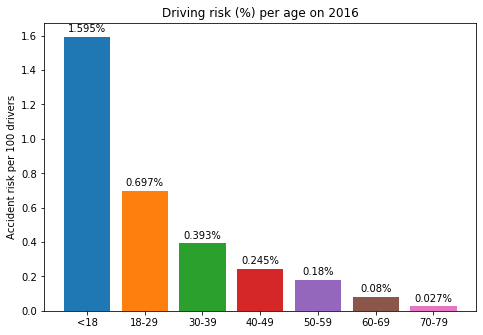

In [11]:
driving_risk = [round((x/y)*100, 3) for x, y in zip(sizes, total_ages)]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for label, size in zip(labels, driving_risk):
    tmp_ax = ax.bar(label, size, label=label)
    autolabel(tmp_ax, "center", sign='%')
plt.title("Driving risk (%) per age on 2016")
plt.ylabel("Accident risk per 100 drivers")
plt.show()

## Histogram: Accidents Per Year

Text(0.5, 0.98, 'Histogram: Accidents Per Year')

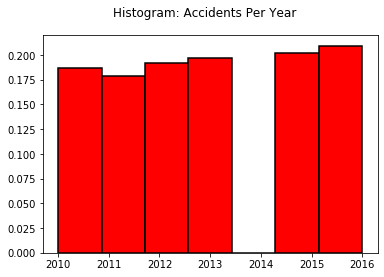

In [12]:
accidents_by_year = dataDF.select("nk_any")

year_lst = [int(row.nk_any) for row in accidents_by_year.collect()]
stats = accidents_by_year.rdd.map(lambda x: int(x[0])).stats()
releases_range = int((stats.max() - stats.min()) + 1)
plt.hist(year_lst, bins=releases_range, color='red', density=True, edgecolor='black', linewidth=1.5)
fig = plt.gcf()
fig.suptitle("Histogram: Accidents Per Year")

## Histogram: Accidents per month in 2016

Text(0.5, 0.98, 'Histogram: Accidents Per Month in 2016')

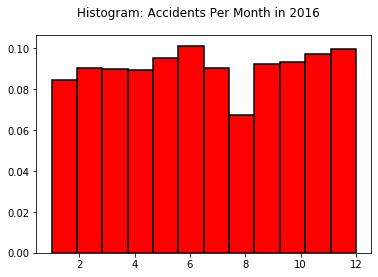

In [13]:
monthDF = dataDF.filter(dataDF.nk_any == "2016").select("mes_de_any")

month_lst = [int(row.mes_de_any) for row in monthDF.collect()]
stats = monthDF.rdd.map(lambda x: int(x[0])).stats()
releases_range = int((stats.max() - stats.min()) + 1)
plt.hist(month_lst, bins=releases_range, color='red', density=True, edgecolor='black', linewidth=1.5)
fig = plt.gcf()
fig.suptitle("Histogram: Accidents Per Month in 2016")


## Histogram: Accidents per day of the week in 2016

Text(0.5, 0.98, 'Histogram: Accidents by week day (Mon to Sun)')

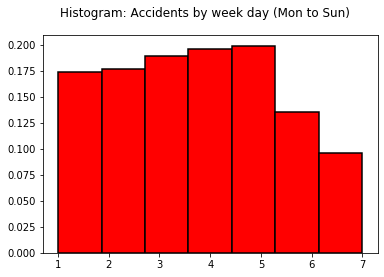

In [14]:
weekDF = dataDF.filter(dataDF.nk_any == "2016").select("dia_setmana")
week_days_distribution = {'Dl':1, 'Dm':2, 'Dc':3, 'Dj':4, 'Dv':5, 'Ds':6, 'Dg':7}

week_rdd = weekDF.rdd.map(lambda x: week_days_distribution[x[0]])
week_days = week_rdd.collect()
stats = week_rdd.stats()
releases_range = int((stats.max() - stats.min()) + 1)
plt.hist(week_days, bins=releases_range, color='red', density=True, edgecolor='black', linewidth=1.5)
fig = plt.gcf()
fig.suptitle("Histogram: Accidents by week day (Mon to Sun)")

## Histogram: Accidents per hour of the day in 2016

Text(0.5, 0.98, 'Histogram: Accidents by hour of the day')

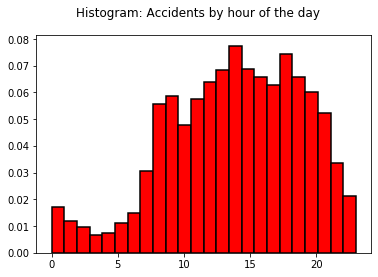

In [15]:
hourDF = dataDF.filter(dataDF.nk_any == "2016").select("hora_de_dia")

hour_rdd = hourDF.rdd.map(lambda x: int(x[0]))
day_hours = hour_rdd.collect()
stats = hour_rdd.stats()
releases_range = int((stats.max() - stats.min()) + 1)
plt.hist(day_hours, bins=releases_range, color='red', density=True, edgecolor='black', linewidth=1.5)
fig = plt.gcf()
fig.suptitle("Histogram: Accidents by hour of the day")

## Accidents per Mode of Transports

In [16]:
transport_groupDF = dataDF.groupby("desc_tipus_vehicle_implicat").count()

transport_type_lst = [row.desc_tipus_vehicle_implicat for row in transport_groupDF.collect()]
transport_count_lst = [row['count'] for row in transport_groupDF.collect()]

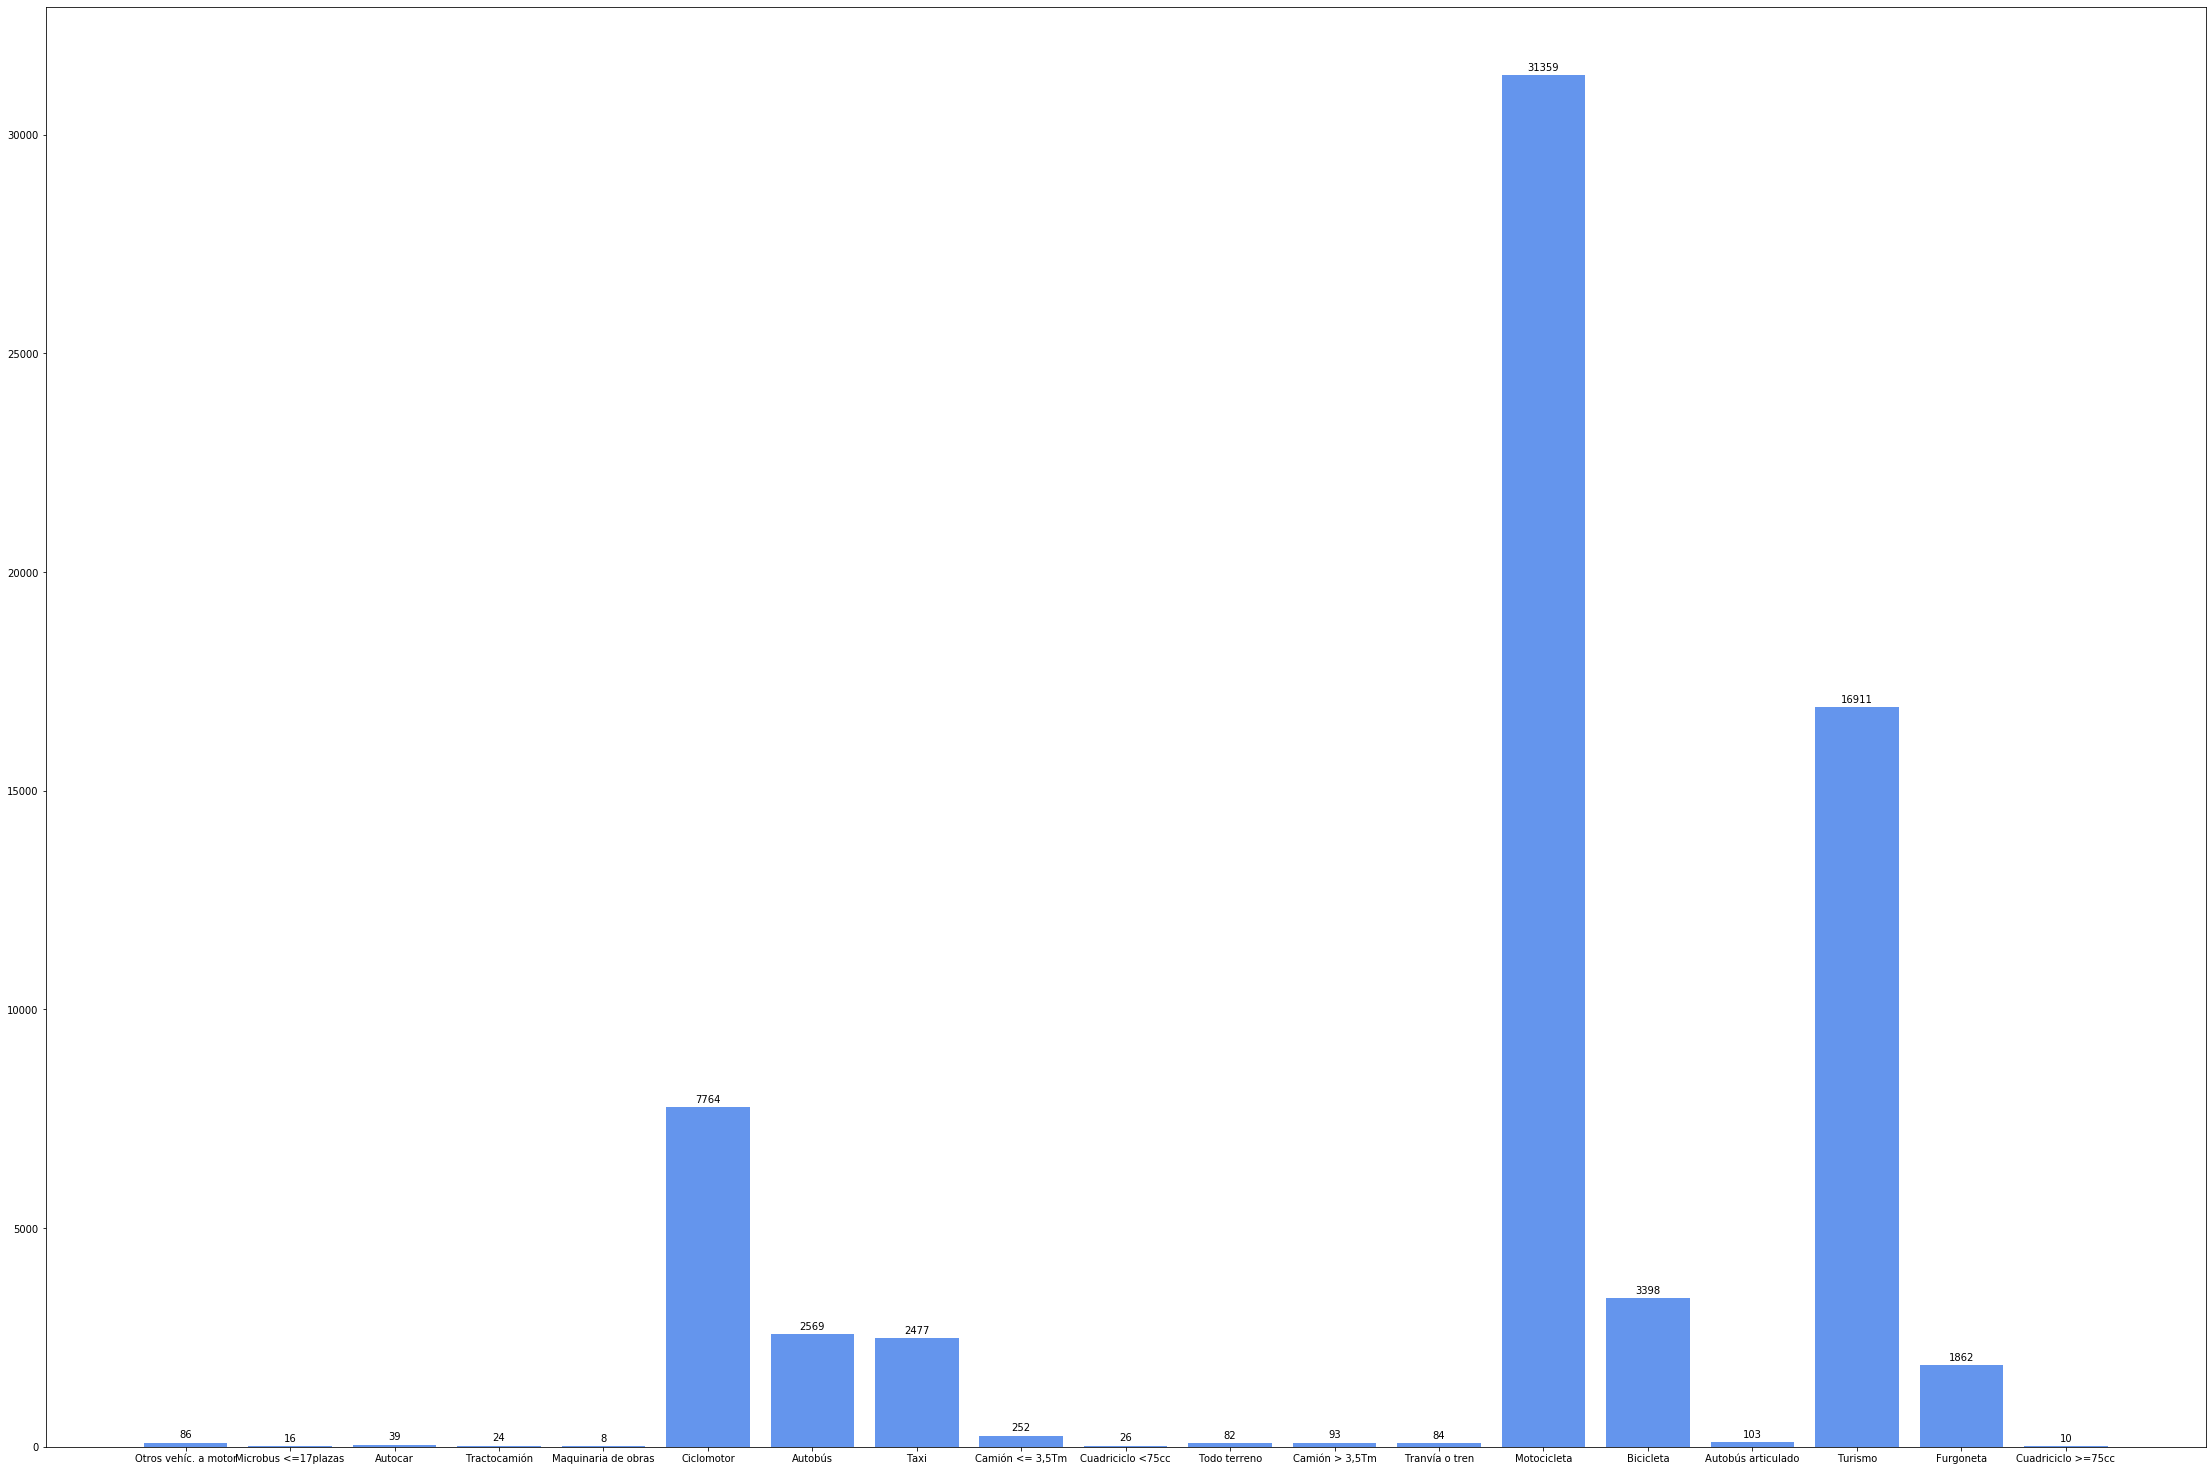

In [17]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

for transport_type, trnaport_count in zip(transport_type_lst, transport_count_lst):
    axbar = ax.bar(transport_type, trnaport_count, color='cornflowerblue')
    autolabel(axbar, "center")

fig.set_size_inches(30, 20)
plt.show()

## Top 3 Transports with most accidents

In [18]:
top3accidents = dataDF.groupby("desc_tipus_vehicle_implicat").count().rdd.takeOrdered(3, key= lambda x: -x[1])
top3transports = [x.desc_tipus_vehicle_implicat for x in top3accidents]

accidents_x_transport_x_year = dataDF.select("nk_any", "desc_tipus_vehicle_implicat").rdd.\
    map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda x, y: x+y).sortByKey(ascending=True).map(lambda x: (x[0][0], x[0][1], x[1])).\
    filter(lambda x: x[1] in top3transports)

moto = []
car = []
moped = []

for x in accidents_x_transport_x_year.collect():
    x[1] == "Motocicleta" and moto.append(x[2])
    x[1] == "Turismo" and car.append(x[2])
    x[1] == "Ciclomotor" and moped.append(x[2])


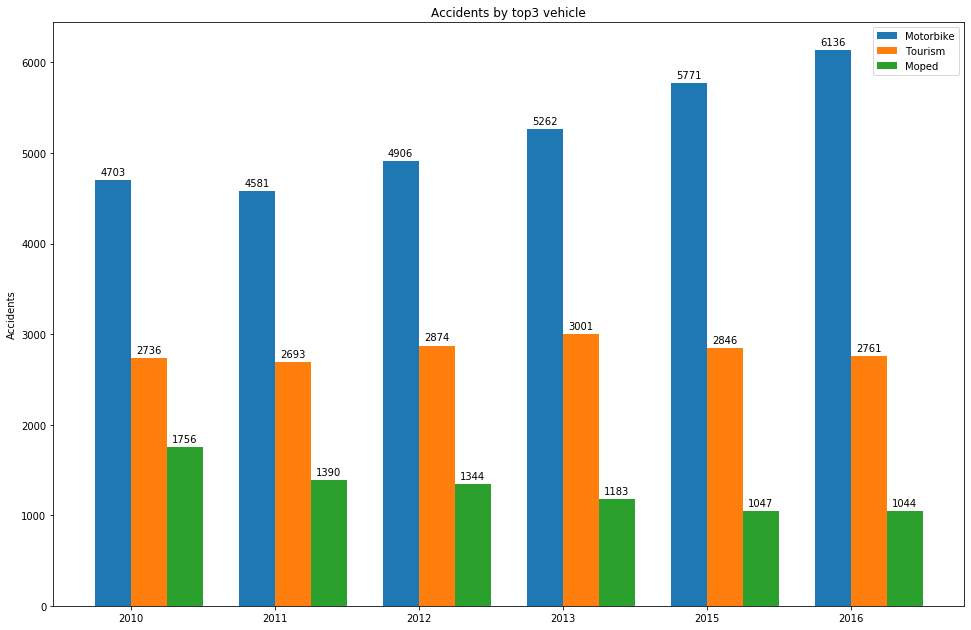

In [19]:
ind = np.arange(len(car))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, moto, width, label='Motorbike')
rects2 = ax.bar(ind + width/2, car, width, label='Tourism')
rects3 = ax.bar(ind + width*1.5, moped, width, label='Moped')

ax.set_ylabel('Accidents')
ax.set_title('Accidents by top3 vehicle')
ax.set_xticks(ind)
ax.set_xticklabels(('2010', '2011', '2012', '2013', '2015', '2016'))
ax.legend()

autolabel(rects1, "center")
autolabel(rects2, "center")
autolabel(rects3, "center")

fig.tight_layout()
fig.set_size_inches(15, 10)
plt.show()

## Accidents per District

In [20]:
from pyproj import Proj
myproj = Proj("+proj=utm +zone=31T, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

coords_DF = dataDF.dropDuplicates(['numero_dexpedient']).filter(dataDF["nk_any"] == "2016").\
    select("codi_districte","nom_districte", "coordenada_utm_(x)", "coordenada_utm_(y)").\
    filter(dataDF.codi_districte != -1).filter(dataDF["coordenada_utm_(x)"] != "-1").filter(dataDF["coordenada_utm_(y)"] != "-1").\
    rdd.\
    map(lambda x: (int(x[0]), (x[1], [float(x[2].replace(",", "."))], [float(x[3].replace(",", "."))]))).\
    reduceByKey(lambda tuple1, tuple2: (tuple1[0],tuple1[1]+tuple2[1], tuple1[2]+tuple2[2])).\
    map(lambda x: (x[0], (x[1][0], myproj(x[1][1], x[1][2], inverse=True)))).\
    sortByKey()

disctrict_names_list = []
x_param = []
y_param = []

for x in coords_DF.collect():
    disctrict_names_list.append(x[1][0])
    x_param.append(x[1][1][0])
    y_param.append(x[1][1][1])

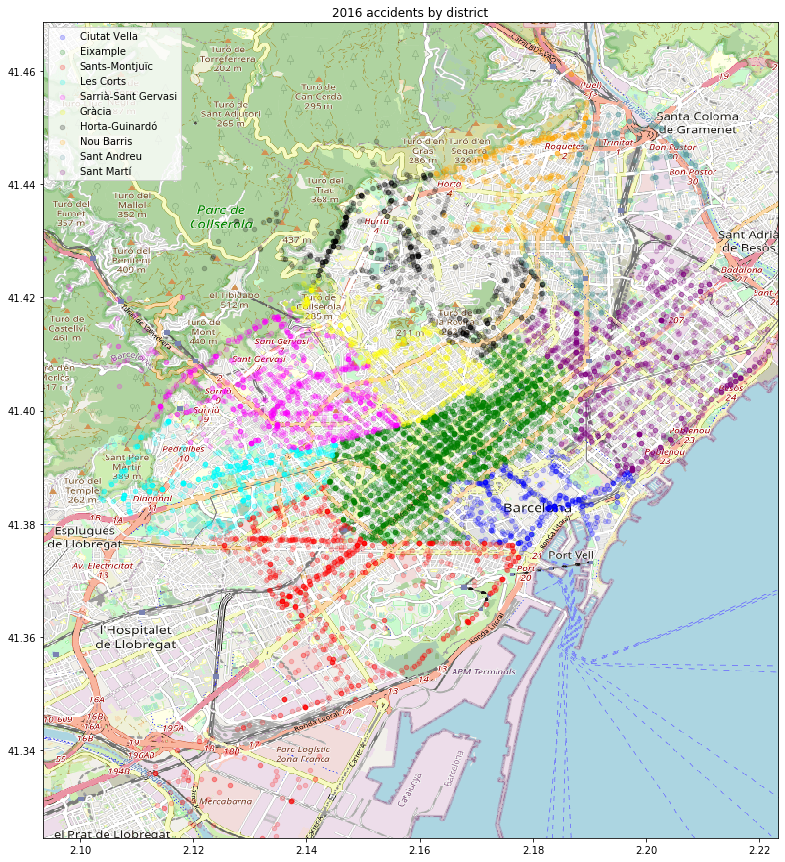

In [21]:
minX = sys.maxsize
maxX = -sys.maxsize - 1
maxY = -sys.maxsize - 1
minY = sys.maxsize
for x in x_param:
    if min(x) < minX:
        minX = min(x)
    if max(x) > maxX:
        maxX = max(x)
        
for y in y_param:
    if min(y) < minY:
        minY = min(y)
    if max(y) > maxY:
        maxY = max(y)

ruh_m = plt.imread('../data/maps/map.png')
BBox = ((minX, maxX, maxY, minY))     
        
fig, ax = plt.subplots(figsize = (20,15))
colour = ["blue", "green", "red", "cyan", "magenta", "yellow", "black", "orange", "cadetblue", "purple"]
for l in range(10):
    ax.scatter(x_param[l],y_param[l], zorder=1, alpha
               = 0.2, c=colour[l], s=20, label=disctrict_names_list[l])

ax.set_title('2016 accidents by district')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.legend()
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.gca().invert_yaxis()
plt.show()